 # Grover's Algorithm and Amplitude Amplification
 
 ## Grover's search algorithm

The algorithm is often described as finding "a needle in a haystack".
Suppose we have a large search space of size $N$, and one (or more) of the elements is special.
If a classical algorithm, in the worst case we would need to look through all $N$ elements to find our solution(s).
In a randomized algorithm, we would expect to find the solution in $\frac{N}{2}$, still $O(N)$.

Grover can do this in about $O(\sqrt{N})$ iterations.

### How does it work

We use a black-box function, or Oracle, that can quickly verify that an input is a solution to some problem.

We can think of this as nudging, or jiggling, the quantum state in a way that attracts it to the desired solution state.

The algorithm then has three steps:

1. Start in complete ignorance (equal superposition).  We setup a state that all possible answers are equally likely by applying the Hadamard gate to all n qubits.

1. Construct an Oracle gate to mark the correct state.

1. Amplify the correct answer by applying the *Grover Diffusion Operator* to reflect the quantum state around the average amplitude.  For each iteration, the amplitude (probability) of the correct answer increases, and the others decrease.

When we  measure the qubits at the end of these iterations, we will have, with a high probability, the correct answer.

As noted in *Neilsen and Cheung*: 

> It seems as though the oracle already *knows* the answer to the search problem; what possible use could it be to have a quantum serach algorithm based upon such oracle consultations?!  The answer is that there is a distinction between *knowing* the solution to a search problem, and being able to *recognize* the solution; the crucial point is that it is possible to do the latter without necessarily being able to do the former.

When looking for $M$ solutions in a search space of size $N$, 
the sum over all non-solutions is the state:

$|\alpha \rangle = \frac{1}{\sqrt{N-M}} \sum^{''}_{x}{|x\rangle}$.

The sum over x which are solutions is:

$|\beta \rangle = \frac{1}{\sqrt{M}} \sum^{'}_{x}{|x\rangle}$.

These states are obviously orthogonal.

We can visualise the Grover operation, $G$, as two rotations in a 2-dimension space, spanned by the starting vector 
$|\psi \rangle = \sqrt{\frac{N-M}{N}}|\alpha\rangle + \sqrt{\frac{M}{N}}|\beta\rangle$,
where $|\psi\rangle$ is the uniform superposition of search space solutions.

So the initial state is in the space spanned by $|\alpha\rangle$ and $|\beta\rangle$

<img src="./image_single_grover_iteration.jpg" alt="drawing" width="500"/>

The Grover operator applies the oracle operator $O$ phase shift to $|\psi\rangle$, to mark the solution.  
$O|\psi\rangle$ is a reflection of the initial state vector $|\psi\rangle$ about the state $|\alpha\rangle$.

The Grover algorithm then applies a $2|\psi\rangle\langle\psi| - I$ reflection about $|\psi\rangle$. 

The pair of reflections is guaranteed to leave the new state $G|\psi\rangle$ in the space spanned by $|\alpha\rangle$ and $|\beta\rangle$.

### QISKIT Implementation

In our set-up, using the QISKIT components, the Oracle marks the correct solution by flipping the *phase* of the correct state.  
We will see that we do this by setting up a Unitary matrix operator, with the phase flipped.

With 4 qubits, we have a hilbert space of size 16
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0

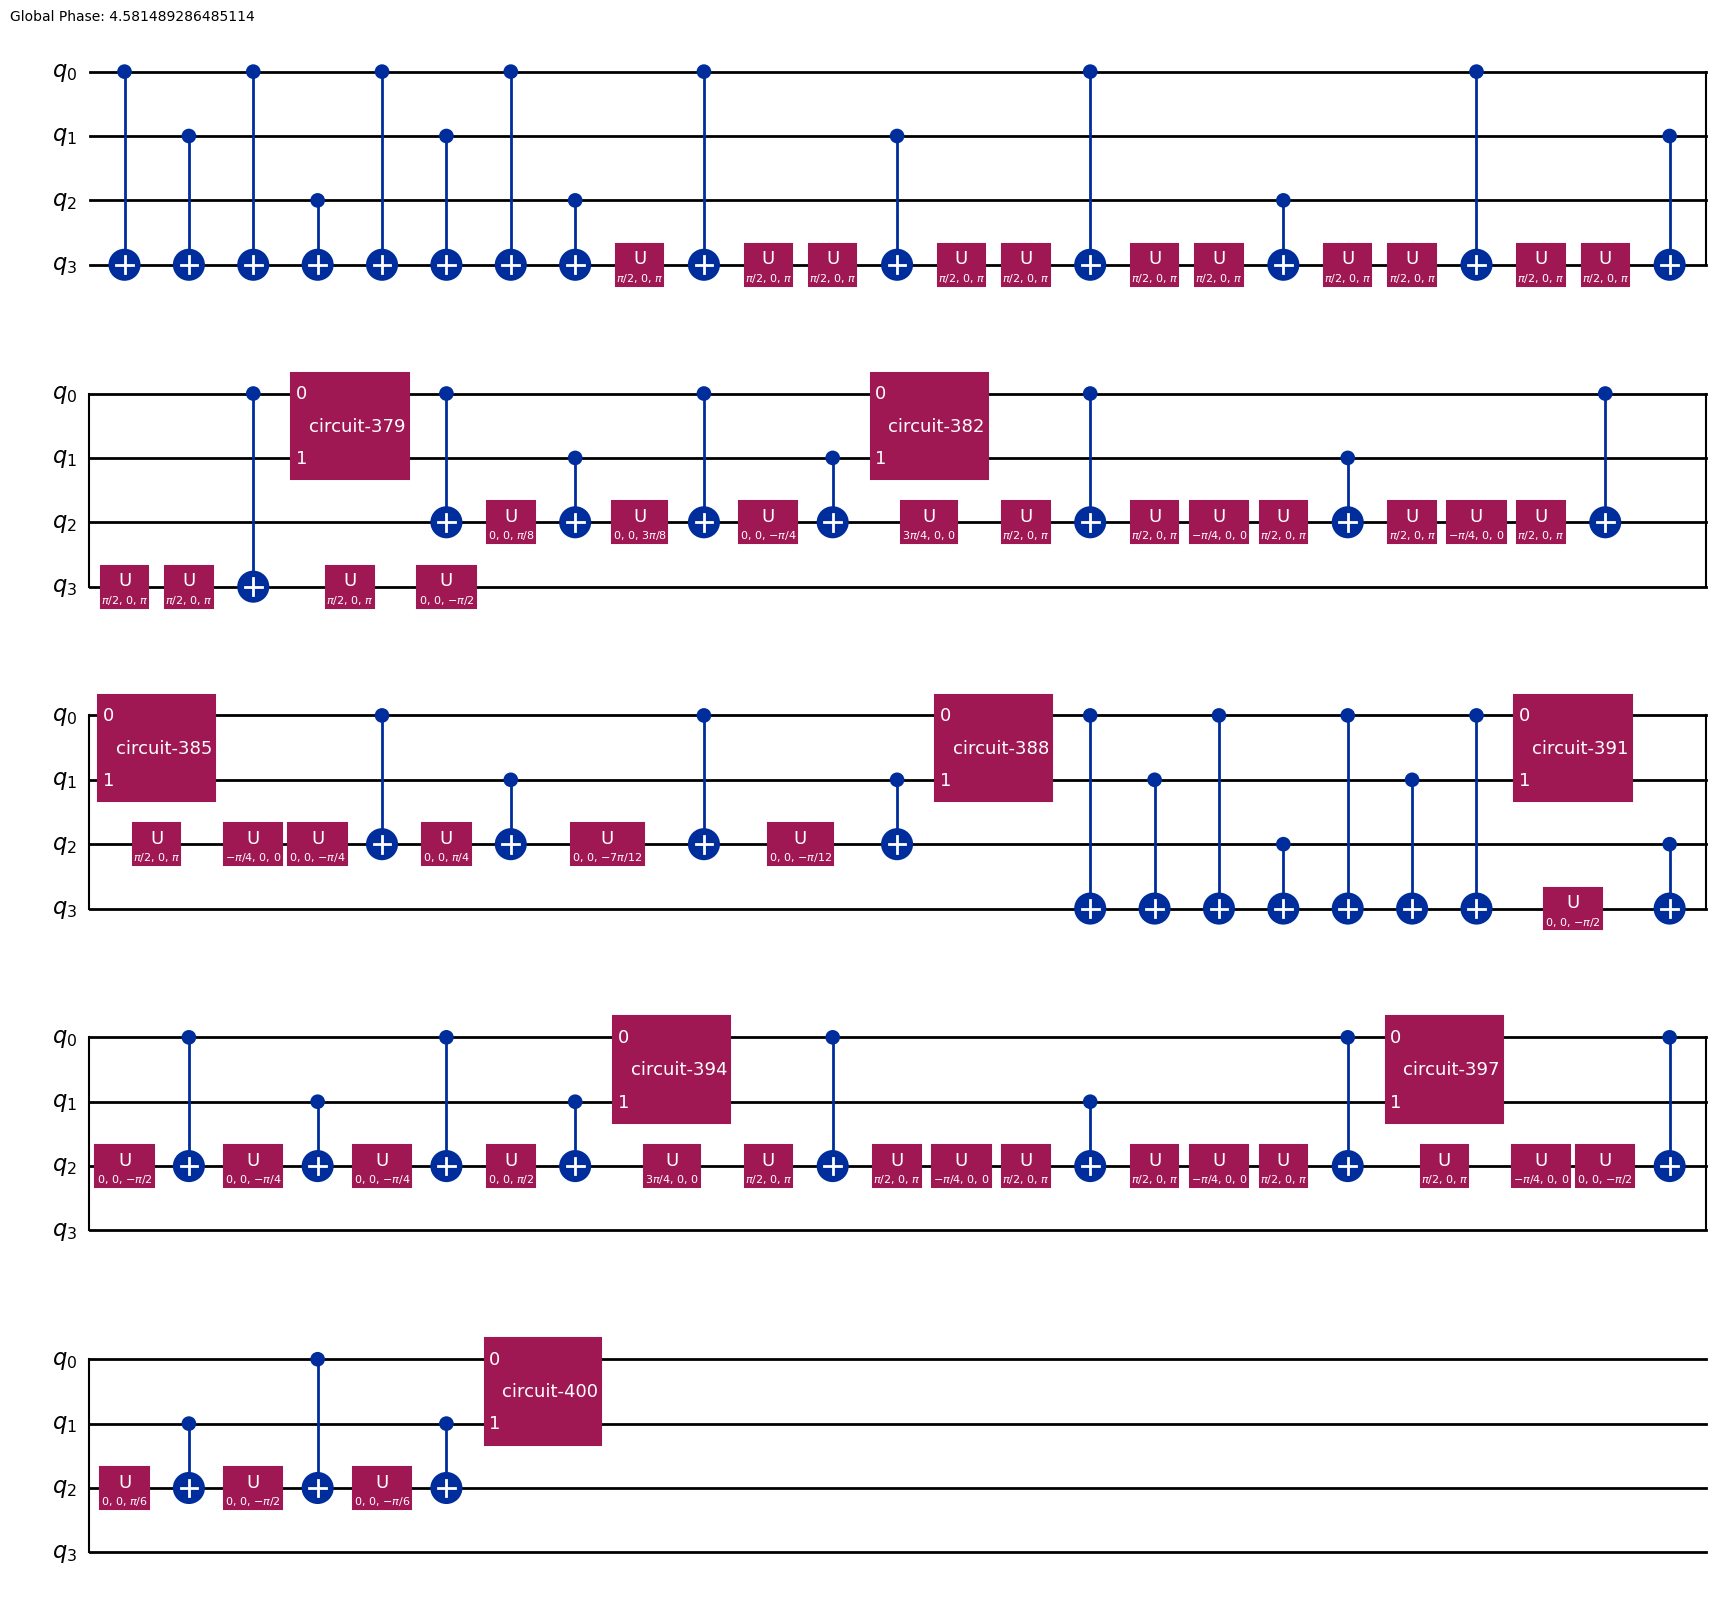

In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import GroverOperator
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

# Create oracle matrix
n = 4
solutions = [3, 5]
size = 2 ** n
oracle = np.eye(size)
for idx in solutions:
    oracle[idx, idx] = -1
print(f"With {n} qubits, we have a hilbert space of size {2 ** n}")
print(oracle)

# Convert to quantum circuit
oracle_circuit = QuantumCircuit(n)
oracle_circuit.unitary(oracle, range(n), label="Oracle")
oracle_circuit.decompose().draw("mpl")

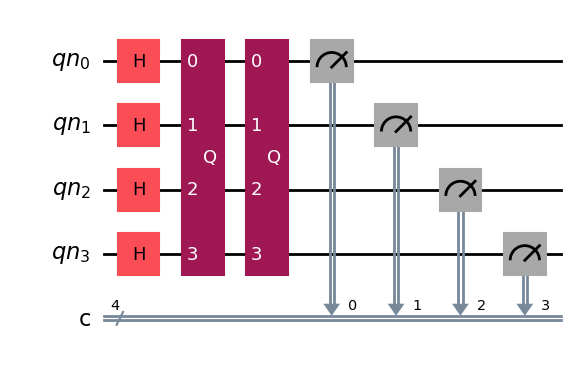

In [2]:
# Calculate optimal number of iterations
k = max(1, int(np.floor((np.pi / 4) * np.sqrt(2 ** n / len(solutions)))), 0)

# Create quantum and classical registers
qn = QuantumRegister(n, 'qn')
c = ClassicalRegister(n, 'c')
qc = QuantumCircuit(qn, c)

# Initialize superposition
qc.h(qn)
        
# Create the grover operator to apply the reflections, and apply for k iterations
grover_operator = GroverOperator(oracle_circuit)

for _ in range(k):
    qc.append(grover_operator, qn)

# Measure results
qc.measure(qn, c)
qc.draw("mpl")

Simple Grover's Algorithm Circuit
Searching for 2 solutions in 16 states
Number of iterations: 2

Circuit Statistics:
Qubits: 4
Gates: 10
Depth: 4


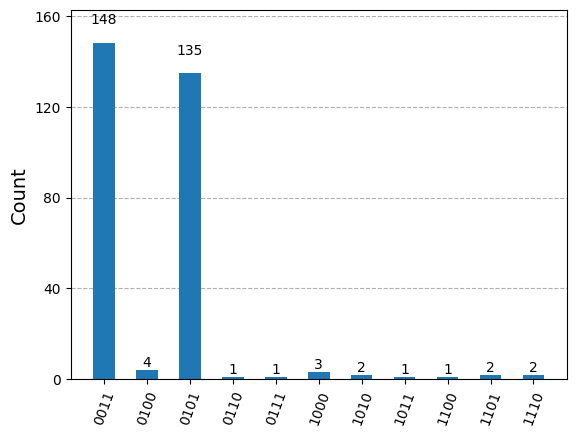

In [3]:
print(f"Simple Grover's Algorithm Circuit\n"
      f"Searching for {len(solutions)} solution{'s' if len(solutions)>1 else ''} "
      f"in {2**n} states\n"
      f"Number of iterations: {qc.count_ops().get('Q', 0)}\n")

print(f"Circuit Statistics:\n"
      f"Qubits: {n}\n"
      f"Gates: {sum(qc.count_ops().values())}\n"
      f"Depth: {qc.depth()}")

# Run simulation
simulator = AerSimulator()
qc_t = transpile(qc, simulator)
result = simulator.run(qc_t, shots=300).result()
counts = result.get_counts()

plot_histogram(counts)

## Further Reading

[Optimizing the Quantum Circuit for Solving Boolean Equations Based on Grover Search Algorithm](https://www.researchgate.net/publication/362576430_Optimizing_the_Quantum_Circuit_for_Solving_Boolean_Equations_Based_on_Grover_Search_Algorithm)